In [262]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Data loading

## Movie data

In [263]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


# TO DO

Observed issues: 

The date format is not constant, sometimes it's the year only, sometimes it's yyyy-mm-dd

Box office revenue is not always available: NaN + Should take into account inflation

For language, countries and genres there's a code in addition to the information (can we use it??)

To check : 

Missing values

Outliars: height way too big 

Are their any duplicated when considering number of movies?

Calculate a weighted rating : vote * rating?

### Find data set with budget spent!!!

## Character data

In [264]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
262595,31839719,/m/0fpmvsn,2011-01-22,Rachel,1993-05-09,F,NaN,NaN,Jamie Lee Redmon,17.0,/m/0gwwhh2,/m/0gwypmd,/m/0gwwhf8
246308,22066393,/m/05p46z2,1956-01-30,La madre di Antonietta,1898-03-27,F,NaN,NaN,Titina De Filippo,NaN,/m/0n649v_,/m/0n66brk,/m/094t9c
414661,11942501,/m/02ryz24,2008-08-13,Oscar Attendee,NaN,F,NaN,NaN,Julie Van,NaN,/m/0gyjwlg,/m/0gyjxk6,/m/0gyjwds
14861,28870327,/m/0dd8qy8,1951-06-29,Upper Classman,1925-11-17,M,1.93,NaN,Rock Hudson,25.0,/m/0gds1j_,/m/0h36vzn,/m/015dcj
153998,4219204,/m/0bc2mh,2005,NaN,1960-06-15,M,NaN,NaN,William Snow,44.0,/m/0h11v94,NaN,/m/02z8jbw


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB data

In [265]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [266]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [267]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [268]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
2730,Nixon,1995,7.1,R,192,"Biography, Drama, History","Dec 20, 1995",45000000,13668249,34668249
3601,Sherrybaby,2006,6.6,R,96,Drama,"Sep 8, 2006",2000000,199176,759504
3154,Captain Fantastic,2016,7.9,R,118,"Comedy, Drama","Jul 8, 2016",5000000,5879835,21340234
2113,Machete,2010,6.6,R,105,"Action, Crime, Thriller","Sep 3, 2010",12500000,26593646,46370970
260,Wild Hogs,2007,5.8,PG-13,100,"Action, Adventure, Comedy","Mar 2, 2007",60000000,168213584,253555383


# Cleaning & Pre-processing of data

In [269]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [270]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [271]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [272]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [273]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [274]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [275]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [276]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [277]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [278]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [279]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [280]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [281]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [282]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

Add ethnicity labels using the freebase ethnicity ids

In [283]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv', index_col=0)

In [284]:
def get_actor_ethnicity_label(row):
    try:
        ethnicity_label = ethnicity_freebase_ids.loc[row['actor_ethnicity_freebase_id'], 'ethnicity_label']
    except:
        ethnicity_label = np.NaN
    return ethnicity_label


In [285]:
characters['actor_ethnicity'] = characters.apply(lambda row: get_actor_ethnicity_label(row),axis=1)

In [286]:
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


In [287]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154809.000000,292175.000000
mean,1.396975e+07,1.748177,37.890901
std,1.079662e+07,0.106249,14.085909
min,3.300000e+02,0.610000,0.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [288]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [289]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [290]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


In [291]:
imdb_top_1000.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime            int64
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross            float64
dtype: object

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on IMDB standard: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

<AxesSubplot:xlabel='IMDB_Rating', ylabel='count'>

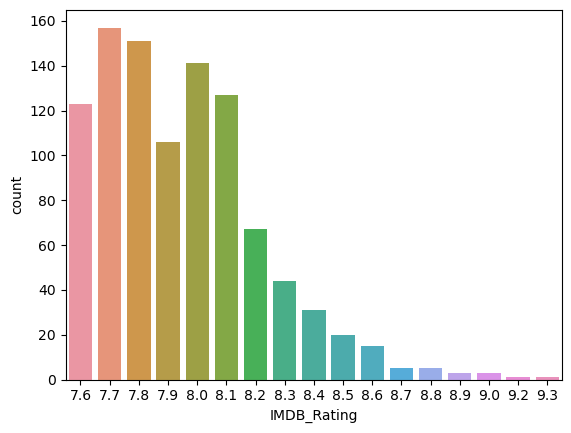

In [292]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000)

In [293]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = imdb_top_1000['No_of_Votes'].min()

In [294]:
imdb_top_1000['No_of_Votes'].count()

1000

In [295]:
imdb_top_1000['WR'] = (imdb_top_1000['No_of_Votes'] / (imdb_top_1000['No_of_Votes'] + m)) * imdb_top_1000['IMDB_Rating'] + (m / (imdb_top_1000['No_of_Votes'] + m)) * C

In [296]:
imdb_top_1000.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,WR
893,https://m.media-amazon.com/images/M/MV5BMjA5Nj...,Sicario,2015,A,121,"Action, Crime, Drama",7.6,An idealistic FBI agent is enlisted by a gover...,82.0,Denis Villeneuve,Emily Blunt,Josh Brolin,Benicio Del Toro,Jon Bernthal,371291,46889293.0,7.622108
245,https://m.media-amazon.com/images/M/MV5BMTY1NT...,"Monsters, Inc.",2001,U,92,"Animation, Adventure, Comedy",8.1,"In order to power the city, monsters have to s...",79.0,Pete Docter,David Silverman,Lee Unkrich,Billy Crystal,John Goodman,815505,289916256.0,8.095502
143,https://m.media-amazon.com/images/M/MV5BY2FhZG...,El secreto de sus ojos,2009,R,129,"Drama, Mystery, Romance",8.2,A retired legal counselor writes a novel hopin...,80.0,Juan José Campanella,Ricardo Darín,Soledad Villamil,Pablo Rago,Carla Quevedo,193217,6391436.0,8.171189
407,https://m.media-amazon.com/images/M/MV5BMzMxZj...,Der Himmel über Berlin,1987,U,128,"Drama, Fantasy, Romance",8.0,An angel tires of overseeing human activity an...,79.0,Wim Wenders,Bruno Ganz,Solveig Dommartin,Otto Sander,Curt Bois,64722,3333969.0,7.985837
23,https://m.media-amazon.com/images/M/MV5BMjlmZm...,Sen to Chihiro no kamikakushi,2001,U,125,"Animation, Adventure, Family",8.6,"During her family's move to the suburbs, a sul...",96.0,Hayao Miyazaki,Daveigh Chase,Suzanne Pleshette,Miyu Irino,Rumi Hiiragi,651376,10055859.0,8.575868


### Merge IMDB database with movie database to have common features

In [297]:
movie_feature = imdb_top_1000.merge(movies, left_on='Series_Title', right_on='name',how='inner')

In [298]:
print(f'There are {movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 875 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81741.


In [299]:
movie_feature.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

### Fill missing budget data from imdb budget dataset

In [300]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1092,The Lucky One,2012,6.5,PG-13,101,"Drama, Mystery, Romance","Apr 19, 2012",25000000,60457138,96633833
1824,Instinct,1999,6.6,R,126,"Drama, Thriller","Jun 4, 1999",55000000,34105207,34105207
2099,Elizabethtown,2005,6.4,PG-13,123,"Comedy, Drama, Romance","Oct 14, 2005",54000000,26850426,50719373
1359,Sleepers,1996,7.6,R,147,"Crime, Drama, Thriller","Oct 18, 1996",44000000,53300852,165600852
2958,The Lost Weekend,1945,7.9,Not Rated,101,"Drama, Film-Noir","Nov 29, 1945",1250000,11000000,11000000


In [301]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


In [302]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date


In [303]:
movie_feature['release_year'] = movie_feature['release_year'].replace('nan', np.nan).astype('Int16')
movie_feature['release_month'] = movie_feature['release_month'].replace('nan', np.nan).astype('Int16')
movie_feature['release_day'] = movie_feature['release_day'].replace('nan', np.nan).astype('Int16')

In [304]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('Int16')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('Int16')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('Int16')

In [305]:
imdb_budget.drop(['Year', 'IMDb', 'Rating', 'Runtime', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'genres', 'Production Budget', 'Domestic Gross',
       'Worldwide Gross', 'release_year', 'release_month', 'release_day'],
      dtype='object')

In [306]:
imdb_budget.describe()

,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,4.030960e+07,5.559021e+07,1.206910e+08,2003.594044,7.322100,15.891066
std,4.480927e+07,7.403263e+07,1.993646e+08,12.767740,3.378479,8.437532
min,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [307]:
movie_feature.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day
count,875.000000,875.000000,763.000000,8.750000e+02,7.400000e+02,875.000000,8.750000e+02,5.240000e+02,818.000000,856.000000,687.000000,666.000000
mean,124.666286,7.934171,78.474443,2.946588e+05,7.572251e+07,7.946205,7.492496e+06,1.398682e+08,118.013203,1981.975467,7.461426,15.442943
std,32.490318,0.275648,12.559687,3.380820e+05,1.095308e+08,0.245880,1.026922e+07,2.506817e+08,35.676872,24.922535,3.472660,8.374175
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611562,3.746000e+03,1.047400e+04,2.000000,1900.000000,1.000000,1.000000
25%,102.000000,7.700000,71.000000,6.353300e+04,6.190768e+06,7.772141,1.715650e+05,1.199760e+07,96.000000,1966.000000,5.000000,9.000000
50%,120.000000,7.900000,79.000000,1.598860e+05,3.530697e+07,7.908277,1.673949e+06,5.111259e+07,114.000000,1989.000000,8.000000,15.000000
75%,138.000000,8.100000,88.000000,4.059220e+05,1.004922e+08,8.064414,1.245293e+07,1.358420e+08,133.000000,2003.000000,10.000000,22.750000
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285691,3.692924e+07,2.782275e+09,360.000000,2014.000000,12.000000,31.000000


In [308]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda x: x.split(', '))

In [309]:
movie_feature.update(imdb_budget)

In [310]:
movie_feature['release_year'] = movie_feature['release_year'].astype('Int16')
movie_feature['release_month'] = movie_feature['release_month'].astype('Int16')
movie_feature['release_day'] = movie_feature['release_day'].astype('Int16')

In [311]:
movie_feature.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day
count,875.000000,875.000000,763.000000,8.750000e+02,7.400000e+02,875.000000,8.750000e+02,5.240000e+02,818.000000,875.000000,875.000000,875.000000
mean,124.666286,7.934171,78.474443,2.946588e+05,7.572251e+07,7.946205,7.492496e+06,1.398682e+08,118.013203,2004.691429,7.432000,15.966857
std,32.490318,0.275648,12.559687,3.380820e+05,1.095308e+08,0.245880,1.026922e+07,2.506817e+08,35.676872,11.834803,3.243142,8.340030
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611562,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000
25%,102.000000,7.700000,71.000000,6.353300e+04,6.190768e+06,7.772141,1.715650e+05,1.199760e+07,96.000000,2000.000000,5.000000,9.000000
50%,120.000000,7.900000,79.000000,1.598860e+05,3.530697e+07,7.908277,1.673949e+06,5.111259e+07,114.000000,2007.000000,7.000000,16.000000
75%,138.000000,8.100000,88.000000,4.059220e+05,1.004922e+08,8.064414,1.245293e+07,1.358420e+08,133.000000,2013.000000,11.000000,23.000000
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285691,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000


In [312]:
imdb_budget.drop(['release_year', 'release_month', 'release_day', 'genres'], axis=1, inplace=True)

In [313]:
movie_feature_with_budget = pd.merge(movie_feature, imdb_budget, on='name',  how='left')

In [314]:
movie_feature_with_budget.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,runtime,languages,countries,genres,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross
322,https://m.media-amazon.com/images/M/MV5BNzZmMj...,Bound by Honor,1993,R,180,"Crime, Drama",8.0,Based on the true life experiences of poet Jim...,47.0,Taylor Hackford,...,330.0,"[Arabic, English, Spanish]",[United States of America],"[Drama, Thriller]",1987,9,18,14000000,156645693,320100000
729,https://m.media-amazon.com/images/M/MV5BZDNiYm...,The Last of the Mohicans,1992,UA,112,"Action, Adventure, Drama",7.7,Three trappers protect the daughters of a Brit...,76.0,Michael Mann,...,230.0,[English],[United States of America],"[Horror, Mystery]",2000,2,4,40000000,89138076,161838076
471,https://m.media-amazon.com/images/M/MV5BMjc4MT...,Spartacus,1960,A,197,"Adventure, Biography, Drama",7.9,The slave Spartacus leads a violent revolt aga...,87.0,Stanley Kubrick,...,188.0,[English],[United States of America],"[Adventure, Drama, Fantasy]",2012,11,21,120000000,124987022,619310368
295,https://m.media-amazon.com/images/M/MV5BNGNiNm...,The Bourne Ultimatum,2007,UA,115,"Action, Mystery, Thriller",8.0,Jason Bourne dodges a ruthless C.I.A. official...,85.0,Paul Greengrass,...,116.0,"[French, Arabic, English, Russian, Spanish]","[United States of America, Germany]","[Action, Adventure, Fantasy]",2010,4,1,15000000,30000000,44400000
594,https://m.media-amazon.com/images/M/MV5BMTkxMj...,Ghostbusters,1984,UA,105,"Action, Comedy, Fantasy",7.8,Three former parapsychology professors set up ...,71.0,Ivan Reitman,...,107.0,[English],[United States of America],[Comedy],2003,8,1,55000000,104354205,126425115


In [315]:
movie_feature_with_budget.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross
count,915.000000,915.000000,802.000000,9.150000e+02,7.740000e+02,915.000000,9.150000e+02,5.520000e+02,855.000000,915.000000,915.000000,915.000000,9.150000e+02,9.150000e+02,9.150000e+02
mean,124.730055,7.939126,78.523691,3.021651e+05,7.623901e+07,7.950792,7.402548e+06,1.430743e+08,118.171696,2004.548634,7.408743,15.864481,8.191084e+07,1.549634e+08,3.609426e+08
std,32.449495,0.279299,12.428475,3.491507e+05,1.091009e+08,0.250022,1.023047e+07,2.509449e+08,35.388353,12.179663,3.239717,8.307756,6.271666e+07,9.880299e+07,3.007794e+08
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611562,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000,3.250000e+05,8.817450e+05,8.817450e+05
25%,102.000000,7.700000,71.000000,6.356000e+04,6.290794e+06,7.773918,1.673350e+05,1.221116e+07,96.000000,1999.000000,5.000000,9.000000,3.200000e+07,9.257084e+07,1.761823e+08
50%,120.000000,7.900000,79.000000,1.644620e+05,3.564609e+07,7.909054,1.643298e+06,5.183651e+07,114.000000,2007.000000,7.000000,16.000000,6.800000e+07,1.250140e+08,2.668243e+08
75%,138.000000,8.100000,88.000000,4.171780e+05,1.009911e+08,8.074631,1.225605e+07,1.479548e+08,133.000000,2013.000000,11.000000,23.000000,1.200000e+08,1.799474e+08,4.328521e+08
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285691,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000,4.000000e+08,8.583730e+08,2.797801e+09


# Exploratory Data Analysis

Looking at the impacts of features on eachother by drawing a correlation heatmap

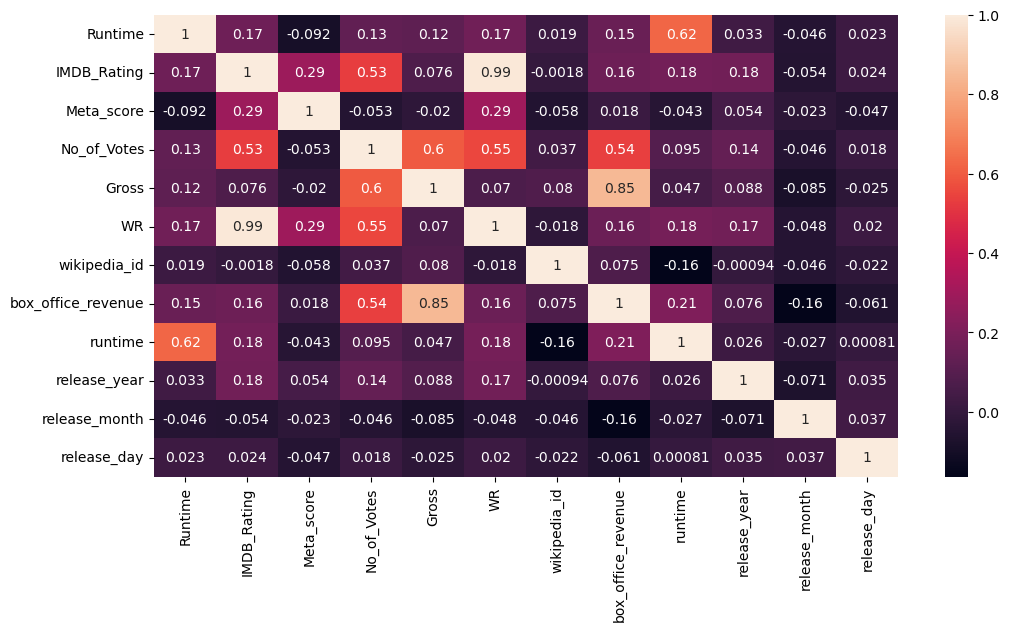

In [316]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(movie_feature.corr(), annot=True, ax=ax);


### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CHECK CORRELATION BETWEEN RATING AND BOX OFFICE REVENUE

In [317]:
df_release = movie_feature.dropna(how='all', subset=['release_month']) # Remove NaN months

In [318]:
movies['release_month'].describe()

count     42667
unique       12
top          09
freq       4268
Name: release_month, dtype: object

In [319]:
df_release.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [320]:
df_release = movies.dropna(how='all', subset=['release_month']) # Remove NaN months


In [321]:
df_release=df_release.sort_values(by='release_month', ascending=True)

In [323]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="WR",data=df_release)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Successfulness of Movie Release By Month', fontsize=14)
plt.savefig('CountbyMonth');

ValueError: Could not interpret input 'WR'

<Figure size 1000x500 with 0 Axes>

## Popular features in characters

Characters dataset splitted in males and females to easily compare among genders

In [324]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

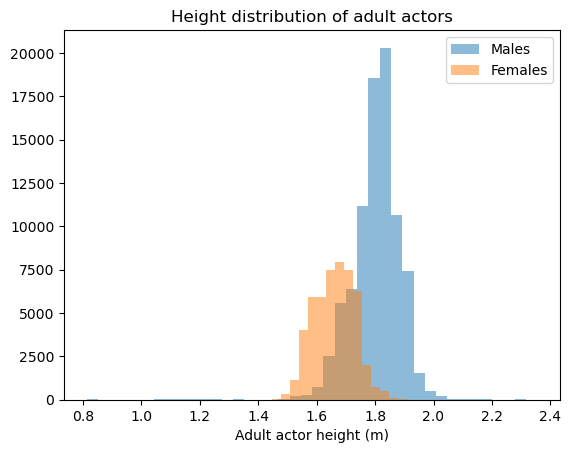

In [325]:
def characters_height_histogram(characters, bins):
    LIMIT_CHILDREN_AGE = 14
    characters_height = characters.dropna(subset=['actor_height_meters'])
    characters_height = characters_height[(characters_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(characters_male, bins=40)
characters_height_histogram(characters_female, bins=25)

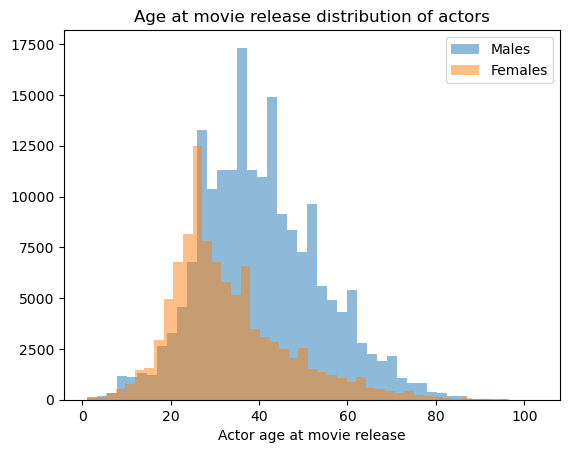

In [326]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

## What genres are the most profitable?

In [327]:
movie_feature_with_budget['profit'] = movie_feature_with_budget['Worldwide Gross'] - movie_feature_with_budget['Production Budget']

<AxesSubplot:title={'center':'Movie profit distribution'}, ylabel='Frequency'>

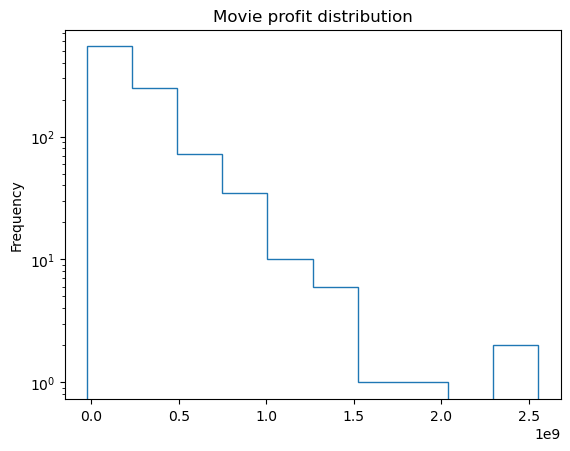

In [328]:
movie_feature_with_budget['profit'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution')

In [329]:
movie_feature_with_budget['genre1'] = movie_feature_with_budget['genres'].apply(lambda el: el[0])

<AxesSubplot:title={'center':'Movie genres distribution'}>

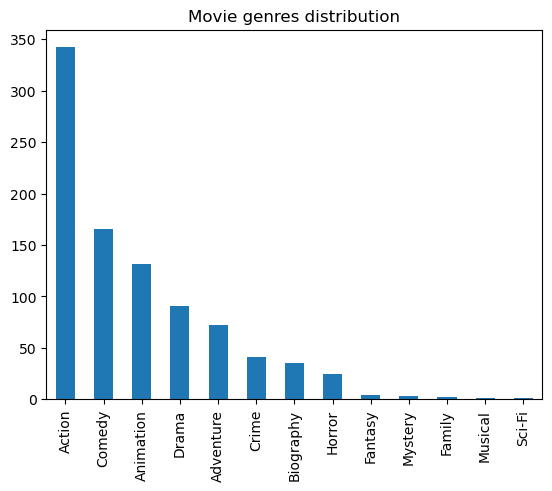

In [330]:
movie_feature_with_budget['genre1'].value_counts().plot(kind='bar', title='Movie genres distribution')

In [331]:
def visualize_genres_profit(genres, means, p025s, p975s, axis, title):
    axis.errorbar(
        np.arange(len(genres)),
        means,
        xerr=0.5,
        yerr=[means - p025s, p975s - means],
        linestyle='', alpha=0.7, color='teal'
    )

    axis.set_title(title)
    print(genres)
    ax.set_xticks(np.arange(len(genres)))
    axis.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(genres))))
    axis.set_xticklabels(genres, rotation=90)


In [332]:
def calculate_average_difference_95_ci(data):
    average_difference = np.mean(data)
    ci_95 = np.percentile(data, [2.5, 97.5])

    return average_difference, ci_95

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Sci-Fi'],
      dtype='object', name='genre1')


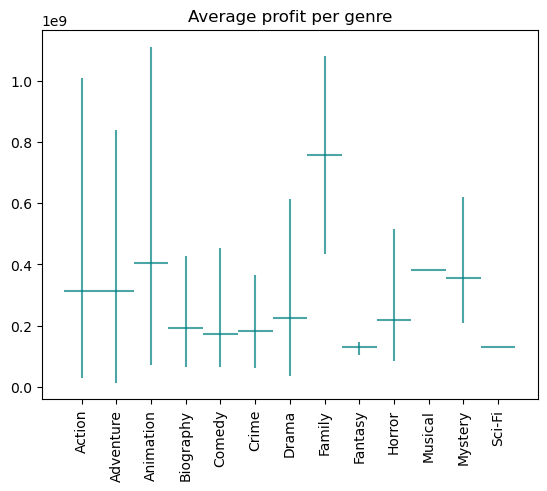

In [333]:
profit = movie_feature_with_budget.groupby('genre1').agg({'profit': calculate_average_difference_95_ci})['profit']

profit_mean = profit.str[0]
profit_p025 = profit.str[1].str[0]
profit_p975 = profit.str[1].str[1]

figure, axis = plt.subplots(1, 1)
visualize_genres_profit(profit_mean.index, profit_mean, profit_p025, profit_p975, axis, 'Average profit per genre')
